In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:

def word_to_action(word, guesses, history):
    return dfword_to_action((word, df.loc[word]), guesses, history)
    
def dfword_to_action(dfword, guesses, history):
    #the action is going to be a word that we will submit next
    #for the purposes of feeding into the model, we will represent the action word as:
    #  how many of the entries in the hint history this word conforms to
    #  how many untried letters it gives us
    #  the number of uniq letters in the word
    #  the frequency of the letters in the word
    #  whether or not the word is in the guess list (as opposed to the target list)
    word = dfword[0]
    dfword = dfword[1]
    
    if guesses:
        conforms_to_history = sum([int(validate_against_hint(word,g,history[i])) for i,g in enumerate(guesses)]) / len(guesses)
    else: # we haven't made any guess yet, so this must conform
        conforms_to_history = 1.0
    num_untried_letters = len(set(word) - set(''.join(guesses))) / 5 #normalise to 1
    action = np.array([conforms_to_history, num_untried_letters, dfword['freq_score'], dfword['uniq_score'], dfword['is_guess_word']])
    
    #if word == 'aargh':
    #    print(f'recons', action, history, guesses)
    return action   
    

def construct_action_vectors_global(arg): #guesses, history, start_idx, end_idx):
    st = time.time()
    guesses, history, start_idx, end_idx = arg
    #print(guesses, history, start_idx, end_idx)
    ret = np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iloc[start_idx:end_idx].iterrows()])
    #print(f'construct_actions_global took {time.time() - st}')
    return ret
           
def construct_action_vectors(guesses, history, df):
        return np.array([dfword_to_action(dfword, guesses, history) for dfword in df.iterrows()])
    
NUM_PROCESSES = mp.cpu_count() - 1
def construct_action_vectors_mp(guesses, history, df):
        grp_lst_args = []
        grp_guesses = [guesses] * NUM_PROCESSES
        grp_history = [history] * NUM_PROCESSES
        
        chunk_size = int(len(df) / NUM_PROCESSES) + 1
        start_offsets = list(range(0, len(df), chunk_size))
        end_offsets = start_offsets[1:] + [len(df)]
        grp_lst_args = list(zip(grp_guesses, grp_history, start_offsets, end_offsets))
        
        #print(grp_lst_args)
        pool = mp.Pool(processes=NUM_PROCESSES)
        results = pool.map(construct_action_vectors_global, grp_lst_args)
        pool.close()
        pool.join()
        return np.concatenate(results)
    
    
def construct_state_vector(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        return np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))


    

   
so the state is going to be:
* The number of green locations we know
*  The number of other letters we know to be in the word
*  The number of letters we know to not be in the word
*  The sequence number of the guess (1st guess, 2nd guess etc.)

the action is going to be a word that we will submit next
for the purposes of feeding into the model, we will represent the action word as:
*  whether or not it conforms to the hint history
*  how many new letters it gives us
*  the number of uniq letters in the word
*  the frequency of the letters in the word

the reward is going to be:
*  the score improvement (if any) gained on the last guess
*  the score will be calculated as 2 * num_green_letters + num_orange_letters

In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
#Get number of actions from gym action space
#n_actions = env.action_space.n
n_action_features = 5
n_state_features = 9
n_input_features = n_action_features + n_state_features


def select_action(policy_net, state, actions, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            #now combine the state (shape 3,) and action (shape 5, n) into one input array (shape 8,n)
            #first expand the state so that it is shape 3,1
            #then repeat it to 3,n
            states = np.repeat(np.expand_dims(state, 0), actions.shape[0], axis=0)
            #print(f'states shape {states.shape} actions shape {actions.shape}')
            #then concatenate to 8,n
            state_actions = np.concatenate((states, actions), axis=1)
            # policy_net(state_action) will return a single value estimate for each state/action row
            # so, probably shape (1,n)
            # Then return the index which has the max value
            
            estimate = policy_net(torch.tensor(state_actions, device=device, dtype=torch.float))
            #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
            return estimate.max(0).indices.item()
    else:
        randindex = random.randrange(len(actions))
        print(f'returning random index {randindex}')
        return randindex #torch.tensor([[randindex]], device=device, dtype=torch.long)



def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [7]:
class DQN(nn.Module):

    def __init__(self, inputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 20)
        self.fc2 = nn.Linear(20, 16)
        self.fc3 = nn.Linear(16, 20)
        self.head = nn.Linear(20, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.head(x)

In [8]:
class LinearQ(nn.Module):

    def __init__(self, inputs):
        super(LinearQ, self).__init__()
        self.head = nn.Linear(inputs, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return self.head(x)

In [9]:
def optimize_model(model, optimizer, memory, batch_size=128):

    transitions = memory.sample(batch_size)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    state_batch = np.stack([tr.state for tr in transitions])
    action_batch = np.stack([tr.action for tr in transitions])
      
    reward_batch = np.stack([tr.reward for tr in transitions])
    state_action_batch = np.concatenate((state_batch, action_batch), axis=1)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_value_estimates = model(torch.tensor(state_action_batch, device=device, dtype=torch.float))
    #print(f'ESTIMATE>>>{estimate.__class__} {estimate.shape} {estimate} {estimate.max(0).indices.item()}<<<')
       
    expected_state_action_values = torch.tensor(reward_batch, device=device, dtype=torch.float)
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_value_estimates, expected_state_action_values)
    
    print(f'loss {loss}')

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss

class TrainConfig():
    def __init__(self, train_interval=128, batch_size=128, clear_memory=False, lr=0.01):
        self.train_interval = train_interval
        self.batch_size = batch_size
        self.clear_memory = clear_memory
        self.lr = lr
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [13]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(clear_memory=False, batch_size=128, train_interval=128)):
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)
    EPS_START = eps[0]
    EPS_END = eps[1]
    EPS_DECAY = eps[2]
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_actions = construct_action_vectors(env.guesses, env.history, env.df)
    starting_state = construct_state_vector(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    if model.name == 'linear':
        policy_net = LinearQ(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    else:
        policy_net = DQN(n_input_features).to(device)
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)

    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        actions = starting_actions
        guesses = []
        for t in count():
            eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            
            epsilons.append(eps)
            #print(epsilons)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            action_idx = select_action(policy_net, state, actions, eps)
            selected_action = actions[action_idx]
            guesses.append(env.word_from_index(action_idx))
            print(f'------guess {t} {action_idx} {guesses[-1]} {selected_action}-------')
            history, reward, done = env.step_by_index(action_idx)
            #here next_state == env.history
            if not done:
                next_state = construct_state_vector(guesses, history)
                actions = construct_action_vectors_mp(guesses, history, env.df)
            
            print(f'reward {reward} done {done} ')
            reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, selected_action, reward)
            episode_memory.append([state, selected_action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                if value_function.name == 'reward':
                    for tr in episode_memory:
                        memory.push(*tr)
                elif value_function.name == 'hybrid':
                    #use the returned reward,
                    #but reduce it if we didn't get the target word by the end of the episode
                    #and increase it if we took less than 6 guesses
                    if episode_reward == 10.0: # if we got the target word
                        #apply a positive factor to all guess values
                        bonus = (env.num_guesses - (t+1)) * GAMMA
                        # after 3 guesses offset = 3* GAMMA
                        # after 6 guesses, offset = 0 * GAMMA 
                    else:
                        bonus = -2*GAMMA
                    
                    print(f'original rewards {[tr[2] for tr in episode_memory]}')
                    for tr in episode_memory:
                        q = max(0.0, tr[2][0] + bonus)
                        tr[2][0] = q
                        memory.push(*tr)
                    print(f'hybrid rewards {[tr[2] for tr in episode_memory]}')    
                elif value_function.name == 'discounted':
                    #q is the actual value of the state_action value function
                    # which is the discounted reward.
                    #on the last guess q(n) is equal to the total episode reward 
                    #and q(n-1) is equal to -1 + episode_reward * GAMMA.
                    #and q(n-2) = -1 + (n-1) * GAMMA
                    #min(q) = -6 (for GAMMA = 1)
                    #max(q) = 10
                    q = episode_reward
                    qs = []
                    if episode_reward < 10: q = q * 0.7 #reduce the reward if we didn't get the correct answer
                    for idx,tr in enumerate(reversed(episode_memory)):
                        if idx > 0:
                            q = -1 + GAMMA * q
                        memory.push(tr[0], tr[1], (q + 6)) # add 6 on to the value so that it is never < 0 
                        qs.append(q+6)
                    print(f'discounted rewards {list(reversed(qs))} vs. {[tr[2] for tr in episode_memory]}')
                else:
                    raise Exception(f'bad value function {value_function.name}')

                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= training.batch_size \
                    and steps_done - last_training > training.train_interval:
                    loss = optimize_model(policy_net, optimizer, memory, batch_size=training.batch_size)
                    losses.append(loss)
                    if training.clear_memory: memory.clear()
                    last_training = steps_done
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 2 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 3 12189 whiny [0.66666667 0.         0.3476069  0.         0.        ]-------
reward 0 done False 
------guess 4 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 5 12189 whiny [0.6       0.        0.3476069 0.        0.       ]-------
reward 0 done True 
episode 0 fi

reward 2.0 done False 
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 1.0 done False 
------guess 2 12189 whiny [0.5       0.        0.3476069 0.        0.       ]-------
reward 0 done False 
------guess 3 11618 imply [0.66666667 0.2        0.39606902 0.         0.        ]-------
reward 2.0 done False 
------guess 4 12722 girly [1.         0.4        0.45029257 0.         0.        ]-------
reward 1.0 done False 
------guess 5 12722 girly [0.8        0.         0.45029257 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [6.]  eps 0.0  gamma 0.0  steps 54  memory 48
original rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
hybrid rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
=========================episode 9 augur======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 don

reward 2.0 done False 
------guess 1 11995 blimp [1.         0.6        0.38265566 0.         0.        ]-------
reward 2.0 done False 
------guess 2 10839 champ [1.         0.6        0.41329332 0.         0.        ]-------
reward 6.0 done True 
episode 18 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 99  memory 96
original rewards [array([2.]), array([2.]), array([6.])]
hybrid rewards [array([2.]), array([2.]), array([6.])]
=========================episode 19 geese======================
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 0 done False 
------guess 1 12097 wight [1.         1.         0.34499625 0.         0.        ]-------
reward 1.0 done False 
------guess 2 12846 clang [1.         0.8        0.47966992 0.         0.        ]-------
reward 0 done False 
------guess 3 11169 grove [1.       0.8      0.528012 0.       0.      ]-------
reward 3.0 done False 
------guess 4 10754 forge [0.75       0.2        0.54064516 0.

reward 3.0 done False 
------guess 1 10683 abase [1.         0.4        0.80822206 0.33333333 0.        ]-------
reward 0 done False 
------guess 2 11785 crest [1.        0.6       0.6844111 0.        0.       ]-------
reward 1.0 done False 
------guess 3 11955 poesy [1.         0.6        0.65590398 0.         0.        ]-------
reward 0 done False 
------guess 4 10710 flesh [1.         0.6        0.58733683 0.         0.        ]-------
reward 6.0 done True 
episode 29 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 148  memory 143
original rewards [array([3.]), array([0]), array([1.]), array([0]), array([6.])]
hybrid rewards [array([3.]), array([0]), array([1.]), array([0]), array([6.])]
=========================episode 30 dryer======================
------guess 0 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 1.0 done False 
------guess 1 12514 rarer [1.         0.4        0.75396849 0.66666667 0.        ]-------
reward 4.0 done False 
------g

reward 1.0 done False 
------guess 1 12458 pasta [1.         0.6        0.71894974 0.33333333 0.        ]-------
reward 0 done False 
------guess 2 11497 kiosk [1.         0.6        0.53629407 0.33333333 0.        ]-------
reward 0 done False 
------guess 3 12590 mucus [1.         0.6        0.47084771 0.33333333 0.        ]-------
reward 6.0 done False 
------guess 4 12214 humus [1.         0.2        0.4628057  0.33333333 0.        ]-------
reward 3.0 done True 
episode 39 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 196  memory 191
original rewards [array([1.]), array([0]), array([0]), array([6.]), array([3.])]
hybrid rewards [array([1.]), array([0]), array([0]), array([6.]), array([3.])]
=========================episode 40 mauve======================
------guess 0 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 2.0 done False 
------guess 1 11855 aware [1.         0.6        0.71534884 0.33333333 0.        ]-------
reward 1.0 done False 
--

reward 1.0 done False 
------guess 1 10951 natal [1.         0.6        0.64810203 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 2 11033 gloat [1.         0.4        0.56228057 0.         0.        ]-------
reward 4.0 done False 
------guess 3 11880 bloat [1.         0.2        0.56177044 0.         0.        ]-------
reward 2.0 done True 
episode 49 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 244  memory 240
original rewards [array([1.]), array([3.]), array([4.]), array([2.])]
hybrid rewards [array([1.]), array([3.]), array([4.]), array([2.])]
=========================episode 50 elegy======================
------guess 0 12179 erase [1.         0.8        0.90433608 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 1 11616 elect [1.         0.6        0.66070518 0.33333333 0.        ]-------
reward 3.0 done False 
------guess 2 12180 elegy [1.         0.4        0.61254314 0.33333333 0.        ]-------
reward 4.0 done True 
episode 50 finished. 

reward 1.0 done False 
------guess 1 11495 title [1.         0.6        0.6116129  0.33333333 0.        ]-------
reward 0 done False 
------guess 2 12772 gooey [1.         0.6        0.57782446 0.33333333 0.        ]-------
reward 5.0 done False 
------guess 3 11002 money [1.        0.4       0.5431958 0.        0.       ]-------
reward 2.0 done False 
------guess 4 11274 honey [1.         0.2        0.53671418 0.         0.        ]-------
reward 0 done False 
------guess 5 12724 boney [1.         0.2        0.53272318 0.         0.        ]-------
reward 2.0 done True 
episode 60 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 294  memory 288
original rewards [array([1.]), array([0]), array([5.]), array([2.]), array([0]), array([2.])]
hybrid rewards [array([1.]), array([0]), array([5.]), array([2.]), array([0]), array([2.])]
=========================episode 61 bluer======================
------guess 0 12179 erase [1.         0.8        0.90433608 0.33333333 0.        ]-------
rewa

reward 5.0 done False 
------guess 1 12151 afire [1.         0.4        0.65068267 0.         0.        ]-------
reward 0 done False 
------guess 2 10727 agree [1.         0.2        0.75366842 0.33333333 0.        ]-------
reward 5.0 done True 
episode 70 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 338  memory 335
original rewards [array([5.]), array([0]), array([5.])]
hybrid rewards [array([5.]), array([0]), array([5.])]
=========================episode 71 alley======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 3.0 done False 
------guess 1 11086 alien [1.         0.6        0.68219055 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11566 alley [1.         0.2        0.64420105 0.33333333 0.        ]-------
reward 4.0 done True 
episode 71 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 341  memory 338
original rewards [array([3.]), array([3.]), array([4.])]
hybrid rewards [array([3.]), array

reward 1.0 done False 
------guess 2 12270 blare [1.        0.2       0.6544036 0.        0.       ]-------
reward 3.0 done False 
------guess 3 12654 flare [1.         0.2        0.63903976 0.         0.        ]-------
reward 2.0 done True 
episode 82 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 383  memory 379
original rewards [array([4.]), array([1.]), array([3.]), array([2.])]
hybrid rewards [array([4.]), array([1.]), array([3.]), array([2.])]
=========================episode 83 tilde======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 11753 utile [1.         0.8        0.58808702 0.         0.        ]-------
reward 3.0 done False 
------guess 2 10818 tilde [1.         0.2        0.58634659 0.         0.        ]-------
reward 5.0 done True 
episode 83 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 386  memory 383
original rewards [array([2.]), array([3.]), array([5.])]
hybrid re

reward 1.0 done False 
------guess 1 10777 pilot [1.         0.8        0.50658665 0.         0.        ]-------
reward 1.0 done False 
------guess 2 10881 could [1.         0.6        0.44414104 0.         0.        ]-------
reward 6.0 done False 
------guess 3 11703 would [1.         0.2        0.41446362 0.         0.        ]-------
reward 2.0 done True 
episode 94 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 429  memory 425
original rewards [array([1.]), array([1.]), array([6.]), array([2.])]
hybrid rewards [array([1.]), array([1.]), array([6.]), array([2.])]
loss 0.8902727365493774
=========================episode 95 bylaw======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 2.0 done False 
------guess 2 11859 bylaw [1.         0.6        0.42313578 0.         0.        ]-------
reward 7.0 done True 
ep

reward 3.0 done False 
------guess 1 12441 tried [1.         0.6        0.60996249 0.         0.        ]-------
reward 4.0 done False 
------guess 2 12115 drier [1.         0.         0.63585896 0.33333333 0.        ]-------
reward 3.0 done True 
episode 106 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 472  memory 469
original rewards [array([3.]), array([4.]), array([3.])]
hybrid rewards [array([3.]), array([4.]), array([3.])]
=========================episode 107 punch======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12840 punch [1.         0.6        0.33818455 0.         0.        ]-------
reward 8.0 done True 
episode 107 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 475  memory 472
original rewards [array([0]), array([2.]), array([8.])]
hybrid rewards [array([0]), ar

reward 2.0 done False 
------guess 1 10752 islet [1.         0.6        0.71273818 0.         0.        ]-------
reward 0 done False 
------guess 2 10764 spend [1.         0.6        0.62268567 0.         0.        ]-------
reward 4.0 done False 
------guess 3 11768 speck [1.         0.4        0.56651163 0.         0.        ]-------
reward 4.0 done True 
episode 119 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 519  memory 515
original rewards [array([2.]), array([0]), array([4.]), array([4.])]
hybrid rewards [array([2.]), array([0]), array([4.]), array([4.])]
loss 0.8818058371543884
=========================episode 120 chest======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 3.0 done False 
------guess 1 10974 heist [1.        0.6       0.6643961 0.        0.       ]-------
reward 3.0 done False 
------guess 2 10938 chest [1.         0.2        0.61245311 0.         0.        ]-------
reward 4.0 done True 
episode 1

reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 3.0 done False 
------guess 2 12818 timid [1.         0.4        0.45737434 0.33333333 0.        ]-------
reward 7.0 done True 
episode 132 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 564  memory 561
original rewards [array([0]), array([3.]), array([7.])]
hybrid rewards [array([0]), array([3.]), array([7.])]
=========================episode 133 vegan======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 12370 leant [1.         0.6        0.66826707 0.         0.        ]-------
reward 2.0 done False 
------guess 2 12739 pecan [1.         0.4        0.58967742 0.         0.        ]-------
reward 2.0 done False 
------guess 3 12404 began [1.        0.4       0.5663916 0.        0.       ]-------
reward 2.0 done False 
------guess 4 12801 vegan [1.        0.2       0.5383946 0

reward 0 done False 
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 3.0 done False 
------guess 2 11115 fungi [1.         0.4        0.35951988 0.         0.        ]-------
reward 7.0 done True 
episode 144 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 611  memory 608
original rewards [array([0]), array([3.]), array([7.])]
hybrid rewards [array([0]), array([3.]), array([7.])]
loss 0.8570311069488525
=========================episode 145 fiber======================
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
------guess 1 12243 liner [1.        0.6       0.6272168 0.        0.       ]-------
reward 4.0 done False 
------guess 2 11858 timer [1.         0.4        0.59564891 0.         0.        ]-------
reward 0 done False 
------guess 3 12024 cider [1.         0.4        0.57194299 0.         0.        ]-------
reward 0 done False 
------guess 4 11434 fiber [1.         

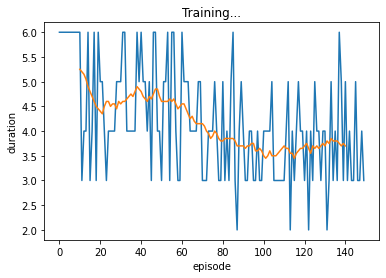

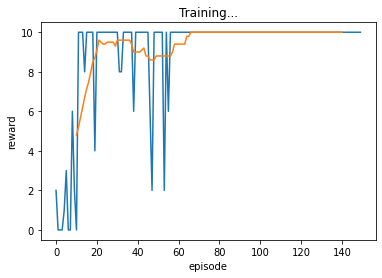

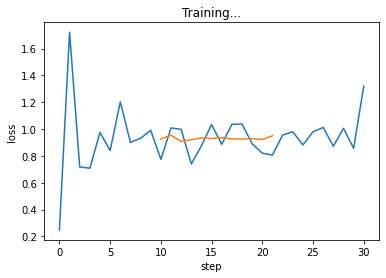

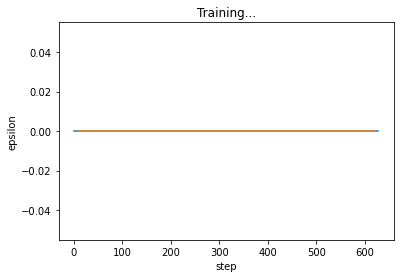

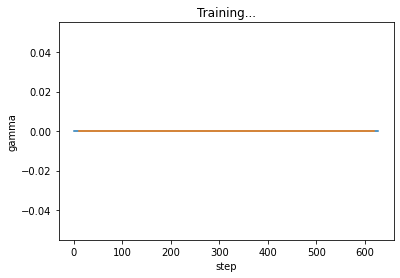

In [11]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=False, lr=0.07)
    ))

pn params [Parameter containing:
tensor([[-0.0020,  0.1434, -0.2200, -0.1967, -0.1029,  0.0717, -0.0053,  0.2119,
         -0.0237,  0.0707, -0.0808, -0.0525, -0.2553, -0.1770]],
       requires_grad=True), Parameter containing:
tensor([-0.1102], requires_grad=True)]
=========================episode 0 lorry======================
[]
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 0 done False 
[]
------guess 2 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
[]
------guess 3 12189 whiny [0.66666667 0.         0.3476069  0.         0.        ]-------
reward 0 done False 
[]
------guess 4 12621 jumpy [0.5        0.         0.26619655 0.         0.        ]-------
reward 0 done False 
[]
------guess 5 12189 whiny [0.6       0.        0.3476069 0.        0.       ]-------
reward 0 done 

reward 2.0 done False 
[]
------guess 1 12189 whiny [1.        0.8       0.3476069 0.        0.       ]-------
reward 1.0 done False 
[]
------guess 2 12189 whiny [0.5       0.        0.3476069 0.        0.       ]-------
reward 0 done False 
[]
------guess 3 11618 imply [0.66666667 0.2        0.39606902 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 4 12722 girly [1.         0.4        0.45029257 0.         0.        ]-------
reward 1.0 done False 
[]
------guess 5 12722 girly [0.8        0.         0.45029257 0.         0.        ]-------
reward 0 done True 
episode 8 finished.  reward [6.]  eps 0.0  gamma 0.0  steps 54  memory 48
original rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
hybrid rewards [array([2.]), array([1.]), array([0]), array([2.]), array([1.]), array([0])]
=========================episode 9 augur======================
[]
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]----

reward 4.0 done False 
[]
------guess 1 12743 guise [1.         0.6        0.63738935 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 2 12731 geese [1.         0.         0.84906227 0.66666667 0.        ]-------
reward 4.0 done True 
episode 19 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 99  memory 30
original rewards [array([4.]), array([2.]), array([4.])]
hybrid rewards [array([4.]), array([2.]), array([4.])]
=========================episode 20 hippo======================
[]
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
[]
------guess 1 10777 pilot [1.         0.8        0.50658665 0.         0.        ]-------
reward 3.0 done False 
[]
------guess 2 11240 mound [0.5       0.8       0.4300075 0.        0.       ]-------
reward 0 done False 
[]
------guess 3 12113 hippo [1.         0.2        0.41995499 0.33333333 0.        ]-------
reward 6.0 done True 
episode 20 finished.  reward [10.]  eps 0.0

reward 0 done False 
[]
------guess 1 12398 sense [1.         0.6        0.8884021  0.66666667 0.        ]-------
reward 1.0 done False 
[]
------guess 2 10728 error [1.         0.4        0.70739685 0.66666667 0.        ]-------
reward 4.0 done False 
[]
------guess 3 12794 mamma [0.         0.         0.53737434 1.         0.        ]-------
reward 0 done False 
[]
------guess 4 12794 mamma [0.         0.         0.53737434 1.         0.        ]-------
reward 0 done False 
[]
------guess 5 12794 mamma [0.         0.         0.53737434 1.         0.        ]-------
reward 0 done True 
episode 30 finished.  reward [5.]  eps 0.0  gamma 0.0  steps 150  memory 12
original rewards [array([0]), array([1.]), array([4.]), array([0]), array([0]), array([0])]
hybrid rewards [array([0]), array([1.]), array([4.]), array([0]), array([0]), array([0])]
=========================episode 31 abode======================
[]
------guess 0 12794 mamma [1.         0.4        0.53737434 1.         0.        

reward 0 done False 
[]
------guess 3 12794 mamma [0.         0.         0.53737434 1.         0.        ]-------
reward 0 done False 
[]
------guess 4 12794 mamma [0.         0.         0.53737434 1.         0.        ]-------
reward 0 done False 
[]
------guess 5 12794 mamma [0.         0.         0.53737434 1.         0.        ]-------
reward 0 done True 
episode 38 finished.  reward [1.]  eps 0.0  gamma 0.0  steps 198  memory 60
original rewards [array([1.]), array([0]), array([0]), array([0]), array([0]), array([0])]
hybrid rewards [array([1.]), array([0]), array([0]), array([0]), array([0]), array([0])]
loss 0.7012908458709717
=========================episode 39 humus======================
[]
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 4.0 done False 
[]
------guess 1 12378 gumbo [1.         0.6        0.36597149 0.         0.        ]-------
reward 0 done False 
[]
------guess 2 11339 humid [1.         0.6        0.37386347 0

reward 1.0 done False 
[]
------guess 1 12905 pinch [1.         0.8        0.37563391 0.         0.        ]-------
reward 5.0 done False 
[]
------guess 2 10867 panic [1.         0.2        0.50256564 0.         0.        ]-------
reward 4.0 done True 
episode 48 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 243  memory 42
original rewards [array([1.]), array([5.]), array([4.])]
hybrid rewards [array([1.]), array([5.]), array([4.])]
=========================episode 49 bloat======================
[]
------guess 0 12621 jumpy [1.         1.         0.26619655 0.         0.        ]-------
reward 0 done False 
[]
------guess 1 12097 wight [1.         1.         0.34499625 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 2 10736 front [1.         0.8        0.47885971 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 3 11880 bloat [1.         0.6        0.56177044 0.         0.        ]-------
reward 6.0 done True 
episode 49 finished.  reward [10

reward 2.0 done False 
[]
------guess 1 12338 olden [1.         0.6        0.59642911 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 2 11002 money [1.        0.4       0.5431958 0.        0.       ]-------
reward 4.0 done False 
[]
------guess 3 11274 honey [1.         0.2        0.53671418 0.         0.        ]-------
reward 0 done False 
[]
------guess 4 12724 boney [1.         0.2        0.53272318 0.         0.        ]-------
reward 2.0 done True 
episode 60 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 290  memory 23
original rewards [array([2.]), array([2.]), array([4.]), array([0]), array([2.])]
hybrid rewards [array([2.]), array([2.]), array([4.]), array([0]), array([2.])]
=========================episode 61 bluer======================
[]
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
[]
------guess 1 12243 liner [1.        0.6       0.6272168 0.        0.       ]-------
reward 3.0 done Fal

reward 1.0 done False 
[]
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 2 11307 ninja [1.         0.4        0.47843961 0.33333333 0.        ]-------
reward 7.0 done True 
episode 72 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 334  memory 3
original rewards [array([1.]), array([2.]), array([7.])]
hybrid rewards [array([1.]), array([2.]), array([7.])]
=========================episode 73 knife======================
[]
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
[]
------guess 1 11753 utile [1.         0.8        0.58808702 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 2 12421 chide [1.       0.6      0.499985 0.       0.      ]-------
reward 0 done False 
[]
------guess 3 11712 knife [1.         0.6        0.47990998 0.         0.        ]-------
reward 6.0 done True 
episode 73 finished.  reward [10.]  eps 0.0  gam

reward 3.0 done False 
[]
------guess 2 10818 tilde [1.         0.2        0.58634659 0.         0.        ]-------
reward 5.0 done True 
episode 83 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 379  memory 48
original rewards [array([2.]), array([3.]), array([5.])]
hybrid rewards [array([2.]), array([3.]), array([5.])]
=========================episode 84 brown======================
[]
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 4.0 done False 
[]
------guess 1 12740 droit [1.         0.6        0.54322581 0.         0.        ]-------
reward 0 done False 
[]
------guess 2 12816 crony [1.        0.6       0.4696174 0.        0.       ]-------
reward 1.0 done False 
[]
------guess 3 11981 grown [1.         0.4        0.42703676 0.         0.        ]-------
reward 3.0 done False 
[]
------guess 4 12880 brown [1.         0.2        0.42652663 0.         0.        ]-------
reward 2.0 done True 
episode 84 finished.  reward [10.]  eps 0.

reward 1.0 done False 
[]
------guess 1 12126 tidal [1.         0.8        0.56618155 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 2 11859 bylaw [1.         0.6        0.42313578 0.         0.        ]-------
reward 7.0 done True 
episode 95 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 425  memory 29
original rewards [array([1.]), array([2.]), array([7.])]
hybrid rewards [array([1.]), array([2.]), array([7.])]
=========================episode 96 hyena======================
[]
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
[]
------guess 1 12370 leant [1.         0.6        0.66826707 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 2 12489 hyena [1.         0.4        0.58328582 0.         0.        ]-------
reward 6.0 done True 
episode 96 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 428  memory 32
original rewards [array([2.]), array([2.]), array([6.])]
hybrid rewards [a

reward 2.0 done False 
[]
------guess 1 12237 clout [1.         0.8        0.46940735 0.         0.        ]-------
reward 1.0 done False 
[]
------guess 2 12839 thong [1.         0.6        0.42277569 0.         0.        ]-------
reward 7.0 done True 
episode 108 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 470  memory 9
original rewards [array([2.]), array([1.]), array([7.])]
hybrid rewards [array([2.]), array([1.]), array([7.])]
=========================episode 109 edict======================
[]
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 1.0 done False 
[]
------guess 1 12899 inlet [1.         0.8        0.60132033 0.         0.        ]-------
reward 3.0 done False 
[]
------guess 2 11462 edict [1.         0.4        0.54604651 0.         0.        ]-------
reward 6.0 done True 
episode 109 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 473  memory 12
original rewards [array([1.]), array([3.]), array([6.])]
hybrid rewards 

reward 3.0 done False 
[]
------guess 1 10974 heist [1.        0.6       0.6643961 0.        0.       ]-------
reward 3.0 done False 
[]
------guess 2 10938 chest [1.         0.2        0.61245311 0.         0.        ]-------
reward 4.0 done True 
episode 120 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 514  memory 53
original rewards [array([3.]), array([3.]), array([4.])]
hybrid rewards [array([3.]), array([3.]), array([4.])]
=========================episode 121 whiny======================
[]
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 0 done False 
[]
------guess 1 11101 unlit [1.         1.         0.47675919 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 2 11476 dying [1.         0.6        0.38655664 0.         0.        ]-------
reward 3.0 done False 
[]
------guess 3 12189 whiny [1.        0.4       0.3476069 0.        0.       ]-------
reward 5.0 done True 
episode 121 finished.  reward [10.]  eps 0.0 

reward 2.0 done False 
[]
------guess 1 12370 leant [1.         0.6        0.66826707 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 2 12739 pecan [1.         0.4        0.58967742 0.         0.        ]-------
reward 2.0 done False 
[]
------guess 3 12404 began [1.        0.4       0.5663916 0.        0.       ]-------
reward 2.0 done False 
[]
------guess 4 12801 vegan [1.        0.2       0.5383946 0.        0.       ]-------
reward 2.0 done True 
episode 133 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 561  memory 32
original rewards [array([2.]), array([2.]), array([2.]), array([2.]), array([2.])]
hybrid rewards [array([2.]), array([2.]), array([2.]), array([2.]), array([2.])]
=========================episode 134 nasal======================
[]
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
[]
------guess 1 11427 snail [1.         0.6        0.68228057 0.         0.        ]-------
reward 3.0 do

reward 3.0 done False 
[]
------guess 2 11115 fungi [1.         0.4        0.35951988 0.         0.        ]-------
reward 7.0 done True 
episode 144 finished.  reward [10.]  eps 0.0  gamma 0.0  steps 603  memory 10
original rewards [array([0]), array([3.]), array([7.])]
hybrid rewards [array([0]), array([3.]), array([7.])]
=========================episode 145 fiber======================
[]
------guess 0 11909 arose [1.        1.        0.8375994 0.        0.       ]-------
reward 2.0 done False 
[]
------guess 1 12243 liner [1.        0.6       0.6272168 0.        0.       ]-------
reward 4.0 done False 
[]
------guess 2 11858 timer [1.         0.4        0.59564891 0.         0.        ]-------
reward 0 done False 
[]
------guess 3 12024 cider [1.         0.4        0.57194299 0.         0.        ]-------
reward 0 done False 
[]
------guess 4 11434 fiber [1.         0.4        0.51975994 0.         0.        ]-------
reward 4.0 done True 
episode 145 finished.  reward [10.]  eps 0.0

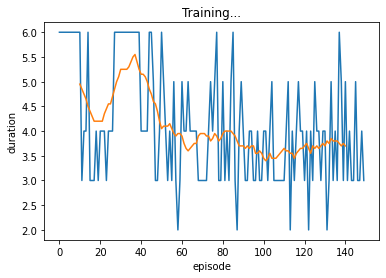

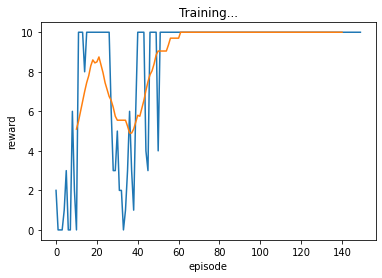

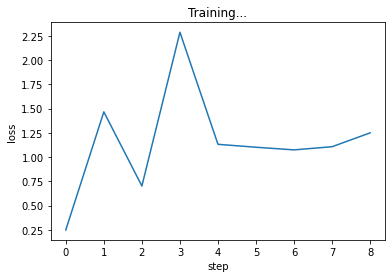

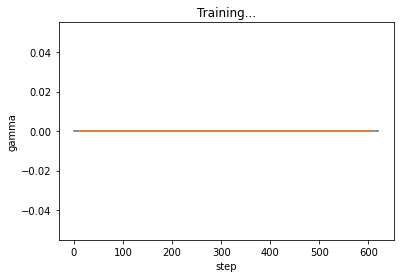

In [12]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    value_function=ValueConfig(name='hybrid', gamma=[0.0, 0.0, 200]),
    eps=[0.0, 0.0, 400],
    num_episodes=150,
    training=TrainConfig(train_interval=16, batch_size=64, clear_memory=True, lr=0.07)
    ))